In [1]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [ ]:
import importlib
import modules.trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_hopper

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.trainer)
importlib.reload(env.custom_hopper)

# Re-import the specific functions into the global namespace
from modules.trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

print("Modules reloaded successfully!")

Modules reloaded successfully!


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-source-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-target-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [3]:
from modules.trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

In [5]:
config = {
    'env_id': 'CustomHopper-source-v0',
    'algo': 'sac',
    'seed': 42,
    'timesteps': 5_000_000,
    'vectorize': True,
    'normalize': True, 
    'lr': 1e-3,
    
    # DORAEMON Settings
    'use_doraemon': True,     # This triggers GaussianHopperWrapper + DoraemonCallback

}

In [6]:
# Training
model, env, doraemon_cb = train_agent(config)

--- STARTING NEW TRAINING ---
Using cpu device
Logging to ./tensorboard_logs/SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.8     |
|    ep_rew_mean     | 18.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3514     |
|    time_elapsed    | 0        |
|    total_timesteps | 95       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 15.8     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 324      |
|    time_elapsed    | 0        |
|    total_timesteps | 168      |
| train/             |          |
|    actor_loss      | -4.97    |
|    critic_loss     | 0.385    |
|    ent_coef        | 0.936    |
|    ent_coef_loss   | -0.333   |
|    learning_rate   | 0.001    |
|    n_updates       | 67       |
---------------------------------

In [ ]:
# ONLY USE IF TRAINING WAS INTERRUPTED AND YOU HAVE CHECKPOINTS

import os
import re

# CHECKPOINT VERIFICATION

checkpoint_dir = "./logs/checkpoints"
if os.path.exists(checkpoint_dir):
    print("Files found:", os.listdir(checkpoint_dir))
else:
    print("No checkpoints found! The interrupt save didn't work.")


# RESUME TRAINING FROM CHECKPOINT

# 1. Find the latest checkpoint step
log_dir = "./logs/"
ckpt_dir = os.path.join(log_dir, "checkpoints")

latest_step = None
if os.path.exists(ckpt_dir):
    # regex to find numbers in filenames
    steps = [int(re.search(r'\d+', f).group()) for f in os.listdir(ckpt_dir) if "model_" in f]
    if steps:
        latest_step = max(steps)

print(f"Resuming from step: {latest_step}")

# 2. Resume Training
if latest_step is not None:
    # Pass the step number to resume_step
    model, env, doraemon_cb = train_agent(config, log_dir=log_dir, resume_step=latest_step)
else:
    print("Could not find a checkpoint to resume.")

In [ ]:
# Used to visualize training metrics through TensorBoard
! tensorboard --logdir ./tensorboard_logs/

# Note: if you want to run Tensorboard from terminal, simply use the command above

/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


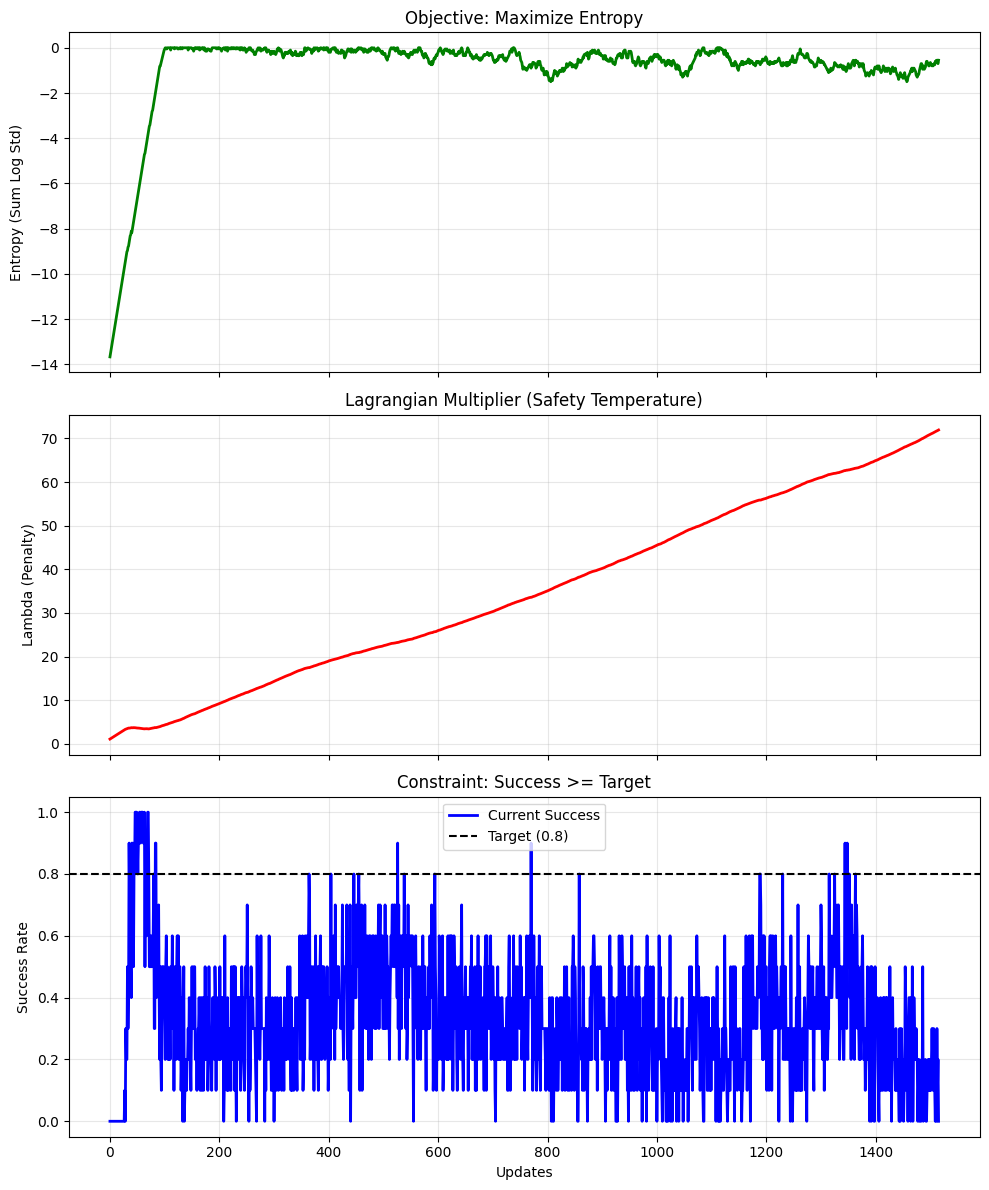

In [7]:
# Plot
# plot_learning_curve("./logs/")
plot_doraemon_dynamics(doraemon_cb) # uses the new function from utils.py

In [20]:
from modules.utils import *

# Define the raw environments
source_env = gym.make('CustomHopper-source-v0')
target_env = gym.make('CustomHopper-target-v0')

# Reconstruct the model name used in training
model_name = f"{config['algo']}_doraemon_{config['seed']}"
model_name = "final"

# Run evaluation
evaluate_sim2real(model, source_env, target_env, log_dir="./logs/", model_name=model_name)

Loaded Normalization stats from ./logs//final_vecnormalize.pkl


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



--- Evaluating on SOURCE Env (Simulation) ---
Reward: 1483.04 +/- 269.27
Length: 353.85 +/- 59.38 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 1333.74 +/- 93.14
Length: 316.50 +/- 20.35 steps


(np.float64(1483.0389488577844), np.float64(1333.7417680561543))

In [ ]:
# RENDERING THE TRAINED AGENT

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import time

# --- CONFIGURATION ---
# Use the same 'model_name' from your previous cell, or type it manually here
# e.g., model_name = "SAC_doraemon_0"
env_to_render = 'CustomHopper-source-v0' # Change to 'target' to see the Real/Shifted env

# 1. Setup the Environment with Rendering Enabled
# render_mode="human" creates the popup window
env = DummyVecEnv([lambda: gym.make(env_to_render, render_mode="human")])

# 2. Load the Normalization Statistics (CRITICAL)
# If you skip this, the agent will see "wrong" numbers and fail immediately
norm_path = f"./logs/{model_name}_vecnormalize.pkl"
try:
    env = VecNormalize.load(norm_path, env)
    # We must disable training and reward normalization for inference
    env.training = False
    env.norm_reward = False
    print(f"Loaded Normalization stats from {norm_path}")
except FileNotFoundError:
    print("Warning: No normalization stats found. Running with RAW observations.")

# 3. Load the Trained Model
model_path = f"./logs/{model_name}_model.zip"
model = SAC.load(model_path)

# 4. The Simulation Loop
print(f"Starting rendering for {env_to_render}...")
obs = env.reset()

try:
    # Run for 1000 steps (or until you stop it)
    for _ in range(1000):
        # Get the action from the agent
        action, _ = model.predict(obs, deterministic=True)
        
        # Step the environment
        obs, rewards, dones, info = env.step(action)
        
        # Render the frame
        env.render()
        
        # Slow down slightly so you can see what's happening (Macs run this very fast)
        time.sleep(0.02)
        
        if dones[0]:
            print("Agent fell over! Resetting...")
            obs = env.reset()
            # time.sleep(1.0) # Pause briefly on failure if you want to see the crash

except KeyboardInterrupt:
    print("Simulation stopped by user.")
finally:
    env.close()

Loaded Normalization stats from ./logs/final_vecnormalize.pkl
Starting rendering for CustomHopper-source-v0...
Agent fell over! Resetting...
Agent fell over! Resetting...
